In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymatreader import read_mat
from matplotlib.animation import FuncAnimation
from scipy.interpolate import interp1d
from scipy.signal import hilbert, windows
import scipy.ndimage

## 파일 불러오기

## Phantom 불러오기

In [2]:
phantom_img_mat = read_mat('data/phantom/phantom_Img.mat')
print(phantom_img_mat.keys())

dict_keys(['img'])


In [3]:
phantom_img = np.array(phantom_img_mat['img'])
print(phantom_img[0])
print(phantom_img.shape)

[[15088.24664395 15731.4438121  12652.59321294 ... 13383.30280452
  13887.28431405 14901.25146003]
 [13080.2430842  12811.73019564 13623.05892076 ... 13825.84057968
  15507.3668615  14307.76929873]
 [16537.70258629 14630.34102005 13189.17756689 ... 15081.56813904
  14565.94019789 15839.17031168]
 ...
 [ 3804.69114414  5799.95956966  4909.88284556 ...  5458.32458843
   4722.34367225  5680.26242622]
 [13782.55193055 12938.61387849 13068.34891985 ... 14645.16790579
  14647.77222972 13915.13172567]
 [ 7044.95022725  7486.1559      7382.89723066 ...  9024.45694985
  11655.7572218   9777.77085918]]
(374, 128, 10)


## Phantom 결과 이미지부터 확인하기

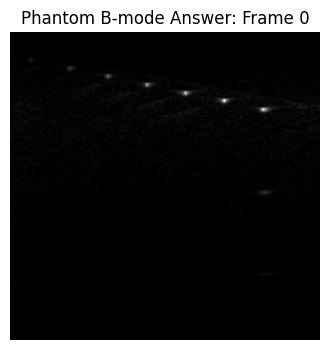

In [4]:
phantom_frame0 = phantom_img[:, :, 0]
plt.figure(figsize=(4, 4))
plt.imshow(phantom_frame0, cmap='gray', aspect='auto', origin='upper')
plt.title('Phantom B-mode Answer: Frame 0')
plt.axis('off')
plt.show()

In [5]:
pantom_rdata_mat = read_mat('data/phantom/phantom_rfdata.mat')
print(pantom_rdata_mat.keys())

dict_keys(['rfdata'])


In [6]:
pantom_rdata = np.array(pantom_rdata_mat['rfdata'])
print(pantom_rdata[0])
print(pantom_rdata.shape)

[[-33 -34 -36 ... -36 -35 -36]
 [-57 -58 -59 ... -62 -58 -56]
 [-40 -42 -45 ... -44 -46 -45]
 ...
 [-46 -48 -46 ... -47 -46 -46]
 [-13 -14 -11 ... -11 -12 -12]
 [-26 -26 -27 ... -25 -26 -27]]
(2176, 128, 100)


## Phantom의 Raw Data Processing

In [7]:
# m으로 통일 시키기 speed of sound가 m/s이므로 
trans_element = 128

#DAS 목표
col_pixels = 128
row_pixels = 2000 # >1600 pixels, 40mm/2000 = 0.02mm
col_spacing = (3.84/col_pixels) * 0.01
row_spacing = (4.0/row_pixels) * 0.01

In [8]:
print(col_spacing)
print(row_spacing)

0.0003
2e-05


In [9]:
delay = np.zeros((row_pixels, col_pixels, trans_element), dtype=np.float32)
x_e = (np.arange(trans_element)-(trans_element-1)/2)*col_spacing
x_p = (np.arange(col_pixels)-(col_pixels-1)/2)*col_spacing
z_p = np.arange(row_pixels) * row_spacing

Xe = x_e.reshape(1, 1, trans_element)   # (1,1,128)
Xp = x_p.reshape(1, col_pixels, 1)   # (1,128,1)
Zp = z_p.reshape(row_pixels, 1, 1)   # (2000,1,1)
distances = np.sqrt((Xp - Xe)**2 + Zp**2)

In [10]:
distances.shape

(2000, 128, 128)

In [11]:
distances

array([[[0.00000000e+00, 3.00000000e-04, 6.00000000e-04, ...,
         3.75000000e-02, 3.78000000e-02, 3.81000000e-02],
        [3.00000000e-04, 0.00000000e+00, 3.00000000e-04, ...,
         3.72000000e-02, 3.75000000e-02, 3.78000000e-02],
        [6.00000000e-04, 3.00000000e-04, 0.00000000e+00, ...,
         3.69000000e-02, 3.72000000e-02, 3.75000000e-02],
        ...,
        [3.75000000e-02, 3.72000000e-02, 3.69000000e-02, ...,
         0.00000000e+00, 3.00000000e-04, 6.00000000e-04],
        [3.78000000e-02, 3.75000000e-02, 3.72000000e-02, ...,
         3.00000000e-04, 0.00000000e+00, 3.00000000e-04],
        [3.81000000e-02, 3.78000000e-02, 3.75000000e-02, ...,
         6.00000000e-04, 3.00000000e-04, 0.00000000e+00]],

       [[2.00000000e-05, 3.00665928e-04, 6.00333241e-04, ...,
         3.75000053e-02, 3.78000053e-02, 3.81000052e-02],
        [3.00665928e-04, 2.00000000e-05, 3.00665928e-04, ...,
         3.72000054e-02, 3.75000053e-02, 3.78000053e-02],
        [6.00333241e-04, 

# 송신 지연을 고려하지 않았을 때

DAS -> Envelope -> Log -> scan conversion

In [12]:
c = 1450 # m/s
center_freq = 7.6e6 # Hz
samples_per_wave = 4.1
fs = center_freq * samples_per_wave

In [ ]:
delay_samples = distances / c * fs
n_samples, n_elements, n_frames = pantom_rdata.shape

beamformed = np.zeros((row_pixels, col_pixels, n_frames), dtype=np.float32)

sample_idx = np.arange(n_samples)    # [0, 1, …, n_samples-1]
window = windows.hann(n_elements, sym=False)

for f in range(n_frames):
    for e in range(n_elements):
        sig = pantom_rdata[:, e, f] #e번째 요소의 raw RF 신호
        ds = delay_samples[:, :, e] #모든 픽셀(i,j)에 대한 e 요소 지연
        #보간 함수를 만든 뒤 실제 ds 위치의 값을 땡겨옴, 즉 interp_func은 각 픽셀에서 요소 e의 지연된 RF 진폭
        interp_func = interp1d( sample_idx, sig, kind='linear', bounds_error=False, fill_value=0.0)(ds)
        beamformed[:, :, f] += interp_func * window[e] #지연된 신호에 apodization 곱하고 더하기

In [14]:
delay_samples

array([[[0.00000000e+00, 6.44689655e+00, 1.28937931e+01, ...,
         8.05862069e+02, 8.12308966e+02, 8.18755862e+02],
        [6.44689655e+00, 0.00000000e+00, 6.44689655e+00, ...,
         7.99415172e+02, 8.05862069e+02, 8.12308966e+02],
        [1.28937931e+01, 6.44689655e+00, 0.00000000e+00, ...,
         7.92968276e+02, 7.99415172e+02, 8.05862069e+02],
        ...,
        [8.05862069e+02, 7.99415172e+02, 7.92968276e+02, ...,
         0.00000000e+00, 6.44689655e+00, 1.28937931e+01],
        [8.12308966e+02, 8.05862069e+02, 7.99415172e+02, ...,
         6.44689655e+00, 0.00000000e+00, 6.44689655e+00],
        [8.18755862e+02, 8.12308966e+02, 8.05862069e+02, ...,
         1.28937931e+01, 6.44689655e+00, 0.00000000e+00]],

       [[4.29793103e-01, 6.46120711e+00, 1.29009543e+01, ...,
         8.05862184e+02, 8.12309079e+02, 8.18755975e+02],
        [6.46120711e+00, 4.29793103e-01, 6.46120711e+00, ...,
         7.99415288e+02, 8.05862184e+02, 8.12309079e+02],
        [1.29009543e+01, 

In [15]:
beamformed

array([[[-1263.2827  , -1302.0287  , -1241.6451  , ..., -1207.4132  ,
         -1209.6637  , -1250.7604  ],
        [-2787.9966  , -2788.556   , -2695.4075  , ..., -2757.2646  ,
         -2807.4575  , -2741.4817  ],
        [-3249.6597  , -3245.5845  , -3281.2368  , ..., -3271.824   ,
         -3280.1501  , -3267.8113  ],
        ...,
        [-3797.8577  , -3851.87    , -3775.8176  , ..., -3820.085   ,
         -3784.493   , -3785.4539  ],
        [ -555.2319  ,  -568.86676 ,  -536.29706 , ...,  -537.4608  ,
          -555.51575 ,  -563.1347  ],
        [  224.53242 ,   286.23206 ,   279.0502  , ...,   248.09946 ,
           260.5458  ,   270.28363 ]],

       [[-1263.1702  , -1301.8884  , -1241.4944  , ..., -1207.2839  ,
         -1209.509   , -1250.6262  ],
        [-2787.1301  , -2787.6907  , -2694.5417  , ..., -2756.3938  ,
         -2806.5957  , -2740.607   ],
        [-3250.7673  , -3246.669   , -3282.279   , ..., -3272.8877  ,
         -3281.2236  , -3268.879   ],
        ...,


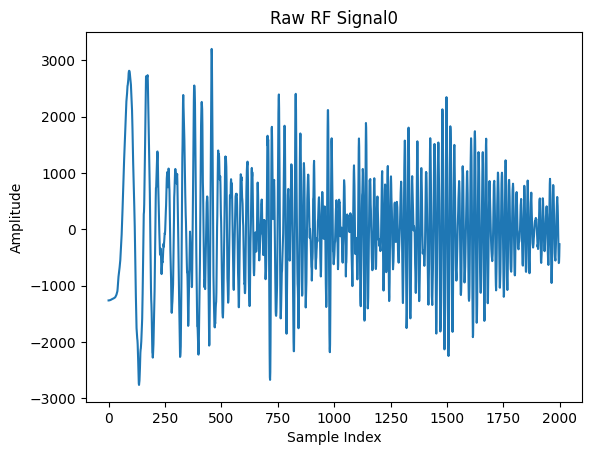

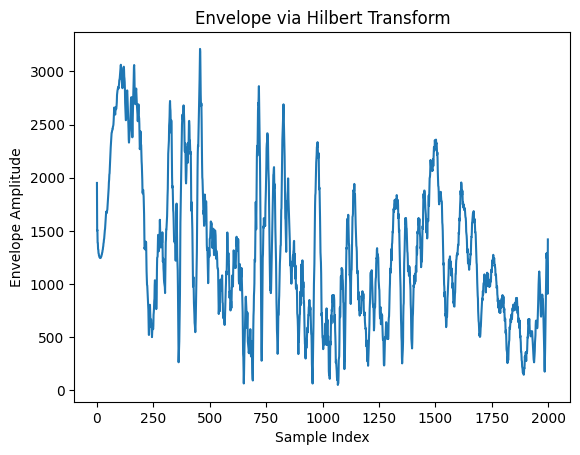

In [16]:
sig_0 = beamformed[:, 0, 0] #0번째 프레임 시그널
envelope_0 = np.abs(hilbert(sig_0, axis = 0))

plt.figure()
plt.plot(sig_0)
plt.title('Raw RF Signal0')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

plt.figure()
plt.plot(envelope_0)
plt.title('Envelope via Hilbert Transform')
plt.xlabel('Sample Index')
plt.ylabel('Envelope Amplitude')
plt.show()

In [21]:
envelope = np.abs(hilbert(beamformed, axis=0))

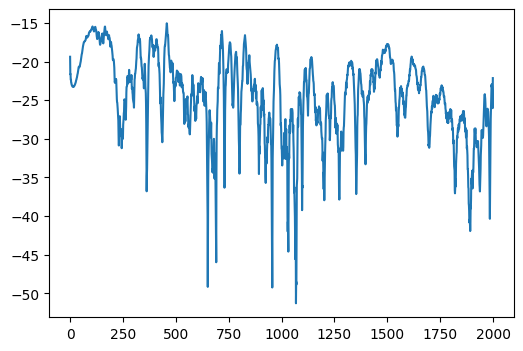

In [27]:
# Log Compression (DR=50 dB)
env0 = envelope[:, :, 0]
env_db = 20*np.log10(env0/np.max(env0)+1e-12)

plt.figure(figsize=(6, 4))
plt.plot(env_db[:,0])
plt.show()

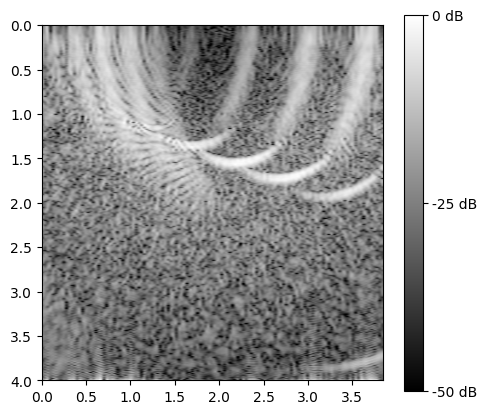

In [ ]:
# scan conversion
env_db_clipped = np.clip(env_db, -50, 0)
bmode_400 = scipy.ndimage.zoom(env_db_clipped,(400/row_pixels, 400/col_pixels))

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bmode_400, cmap='gray', vmin=-50, vmax=0, origin='upper', extent=[0, 3.84, 4.0, 0])

cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
cbar.set_ticks([-50, -25, 0])
cbar.set_ticklabels(['-50 dB', '-25 dB', '0 dB'])

plt.tight_layout()
plt.show()

# 송신 지연을 고려했을 때

In [34]:
print("Zp:", Zp[:5,0,0])
print("distances (첫 열):", distances[:5,0,0])

Zp: [0.e+00 2.e-05 4.e-05 6.e-05 8.e-05]
distances (첫 열): [0.e+00 2.e-05 4.e-05 6.e-05 8.e-05]


In [ ]:
delay_rx = (distances / c) * fs

total_path = Zp + distances  
delay_tx_rx = (total_path / c) * fs

print(np.allclose(delay_rx, delay_tx_rx))  # → False
# 차이 확인
print("row=1, col=0, elem=0 → rx:", delay_rx[1,0,0], "tx+rx:", delay_tx_rx[1,0,0])

False
row=1, col=0, elem=0 → rx: 0.42979310344827587 tx+rx: 0.8595862068965517


In [ ]:
n_samples, n_elements, n_frames = pantom_rdata.shape

beamformed2 = np.zeros((row_pixels, col_pixels, n_frames), dtype=np.float32)

sample_idx = np.arange(n_samples)    # [0, 1, …, n_samples-1]

theta = np.deg2rad(30)
max_lateral = z_p / np.cos(theta/2)
mask = distances <= max_lateral[:,None,None]

w = windows.hann(n_elements, sym=False)  # (128,)

for f in range(n_frames):
    for e in range(n_elements):
        sig = pantom_rdata[:, e, f] 
        ds = delay_tx_rx[:, :, e]
        interp_func = interp1d(sample_idx, sig, kind='linear', bounds_error=False,fill_value=0.0)
        delayed = interp_func(ds) 
        delayed[~mask[:,:,e]] = 0
        beamformed2[:,:,f] += delayed * w[e]

In [37]:
beamformed2

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-3.43294963e-02, -3.49317715e-02, -3.55340429e-02, ...,
         -3.73408571e-02, -3.49317715e-02, -3.37272249e-02],
        [-9.63054672e-02, -1.01120740e-01, -1.08343653e-01, ...,
         -1.05936013e-01, -1.10751286e-01, -1.08343653e-01],
        ...,
        [-2.48940274e-01, -2.59763747e-01, -2.48940274e-01, ...,
         -2.54352003e-01, -2.48940274e-01, -2.48940274e-01],
        [-3.12992781e-02, -3.37069146e-02, -2.64840033e-02, ...,
         -2.64840033e-02, -2.88916398e-02, -2.88916398e-02],
        [-1.56590696e-02, -1.56590696e-02, -1.62613411e-02, ...,
         -1.50567973e-02, -1.56590696e-02, -1.62613411e-02]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-5.55553883e-02, -5.56399561e-02, -5.62422276e-02, ...,
         -5.49428128e-02, -5.40868416e

## Phantom Envelope

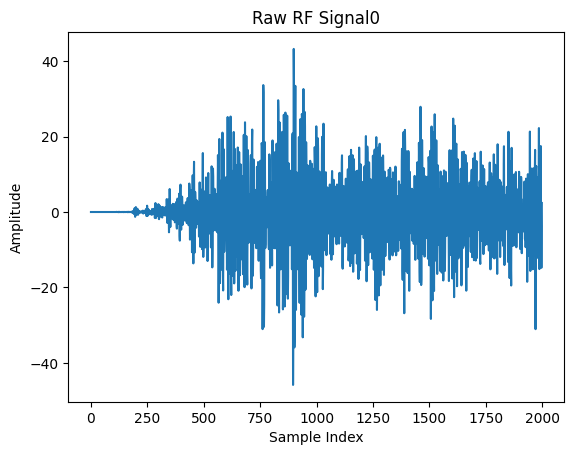

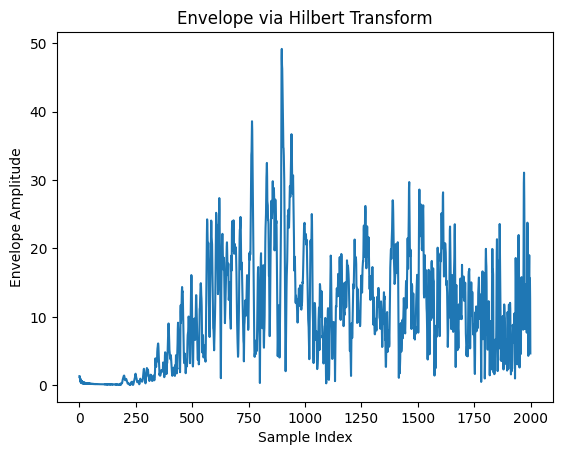

In [38]:
sig_02 = beamformed2[:, 0, 0] #0번째 프레임 시그널
analytic_sig_02 = hilbert(sig_02, axis = 0)
envelope_02 = np.abs(analytic_sig_02)

plt.figure()
plt.plot(sig_02)
plt.title('Raw RF Signal0')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

plt.figure()
plt.plot(envelope_02)
plt.title('Envelope via Hilbert Transform')
plt.xlabel('Sample Index')
plt.ylabel('Envelope Amplitude')
plt.show()

In [ ]:
# 5) Envelope Detection
envelope2 = np.abs(hilbert(beamformed2, axis=0))

## Phantom Log Compression & Scan Conversion

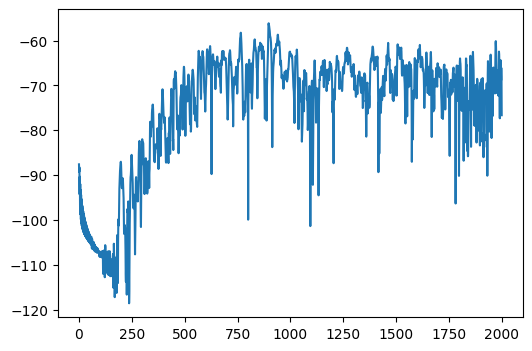

In [40]:
# 7) Log Compression (DR=50 dB)
env0 = envelope2[:, :, 0]
env_db = 20*np.log10(env0/np.max(env0)+1e-12)

plt.figure(figsize=(6, 4))
plt.plot(env_db[:,0])
plt.show()

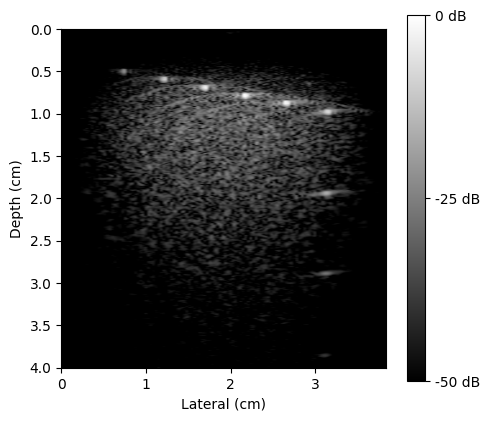

In [ ]:
env_db_clipped = np.clip(env_db, -50, 0)
bmode_400 = scipy.ndimage.zoom(env_db_clipped,(400/row_pixels, 400/col_pixels))

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bmode_400, cmap='gray', vmin=-50, vmax=0, origin='upper', extent=[0, 3.84, 4.00, 0])
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
cbar.set_ticks([-50, -25, 0])
cbar.set_ticklabels(['-50 dB','-25 dB','0 dB'])
ax.set_xlabel('Lateral (cm)')
ax.set_ylabel('Depth (cm)')
plt.tight_layout()
plt.show()

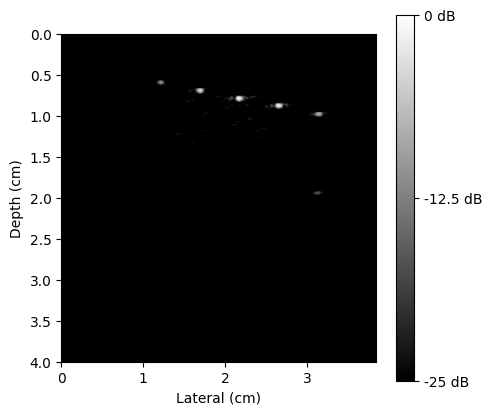

In [ ]:
env_db_clipped25 = np.clip(env_db, -25, 0)
bmode25 = scipy.ndimage.zoom(env_db_clipped25,(400/row_pixels, 400/col_pixels))

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bmode25, cmap='gray', vmin=-25, vmax=0, origin='upper', extent=[0, 3.84, 4.00, 0])
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
cbar.set_ticks([-25, -12.5, 0])
cbar.set_ticklabels(['-25 dB','-12.5 dB','0 dB'])
ax.set_xlabel('Lateral (cm)')
ax.set_ylabel('Depth (cm)')
plt.tight_layout()
plt.show()

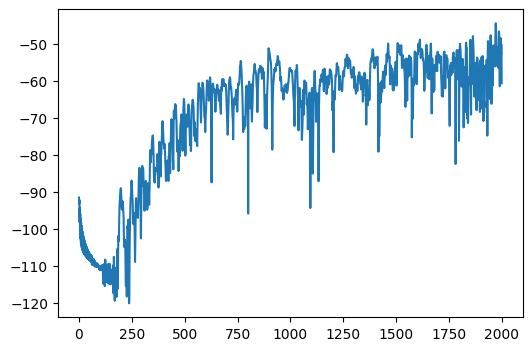

In [44]:
#TGC 고려
Gmax_db = 20
gain_db = np.linspace(0, Gmax_db, row_pixels)
gain_linear= 10**(gain_db/20)
envelope_tgc = envelope2 * gain_linear[:, None, None]

envtgc = envelope_tgc[:, :, 0]
env_dbt = 20*np.log10(envtgc/np.max(envtgc)+1e-12)

plt.figure(figsize=(6, 4))
plt.plot(env_dbt[:,0])
plt.show()

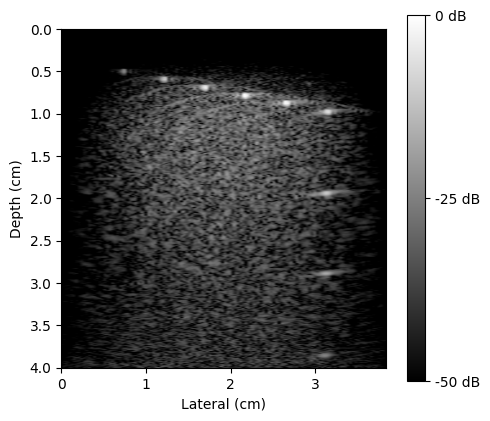

In [ ]:
env_cli_tgc = np.clip(env_dbt, -50, 0)
bmode_tgc = scipy.ndimage.zoom(env_cli_tgc,(400/row_pixels, 400/col_pixels))

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bmode_tgc, cmap='gray', vmin=-50, vmax=0, origin='upper', extent=[0, 3.84, 4.00, 0])
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
cbar.set_ticks([-50, -25, 0])
cbar.set_ticklabels(['-50 dB','-25 dB','0 dB'])
ax.set_xlabel('Lateral (cm)')
ax.set_ylabel('Depth (cm)')
plt.tight_layout()
plt.show()

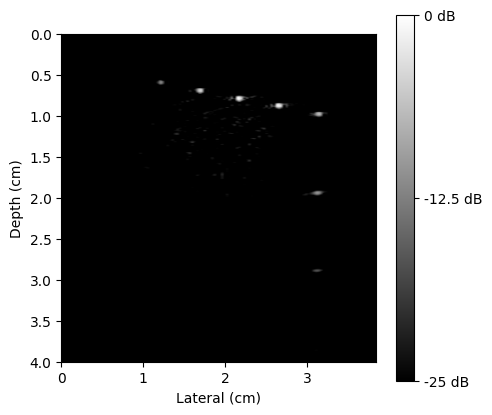

In [ ]:
env_cli_tgc = np.clip(env_dbt, -25, 0)
bmode_tgc = scipy.ndimage.zoom(env_cli_tgc,(400/row_pixels, 400/col_pixels))

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bmode_tgc, cmap='gray',vmin=-25, vmax=0, origin='upper',extent=[0, 3.84, 4.00, 0])
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
cbar.set_ticks([-25, -12.5, 0])
cbar.set_ticklabels(['-25 dB','-12.5 dB','0 dB'])
ax.set_xlabel('Lateral (cm)')
ax.set_ylabel('Depth (cm)')
plt.tight_layout()
plt.show()